 preprocessing 

In [2]:
import numpy as np 
import tensorflow as tf 
from tensorflow import keras 
from keras import layers 
import matplotlib.pyplot as plt 

In [3]:
batch_size_ = 32 
img_size_ = (160,160)
directory = "datasets/dataset/"
train_set = keras.preprocessing.image_dataset_from_directory(
    directory+"train",
    shuffle = True , 
    image_size=img_size_,
    batch_size=batch_size_
)
validation_set = keras.preprocessing.image_dataset_from_directory(
    directory+"test",
    shuffle = True , 
    image_size = img_size_,
    batch_size = batch_size_
)

Found 250 files belonging to 2 classes.
Found 77 files belonging to 2 classes.


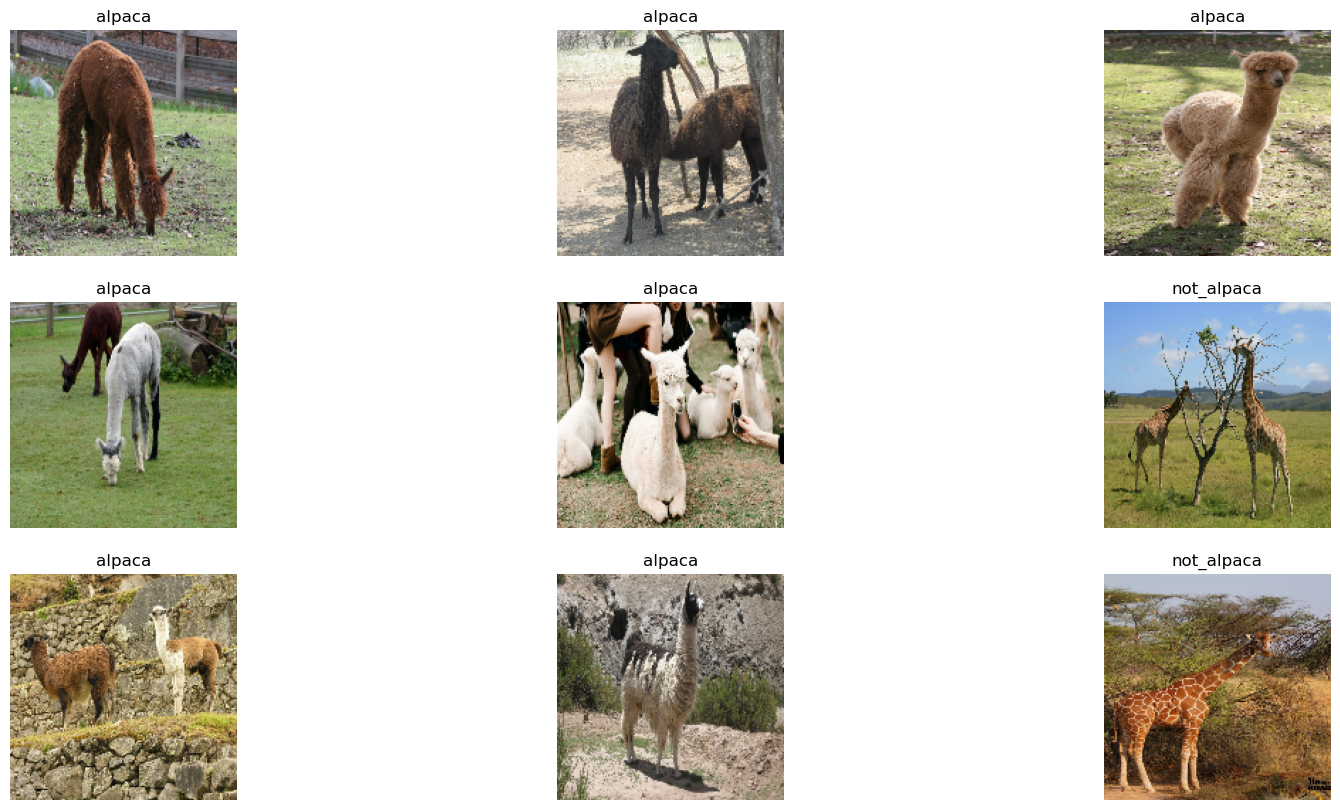

In [4]:
classes = train_set.class_names
plt.figure(figsize=(20,10))
for x,y in train_set.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.title(classes[y[i].numpy()])
        plt.imshow(x[i].numpy().astype("uint8"))
        plt.axis("off")
       

we use prefetch beacuse we wnt to prevent memory bottleneck

In [5]:
autotune_ = tf.data.experimental.AUTOTUNE
train_set = train_set.prefetch(autotune_)

resizing and rescalling 

In [6]:
rescale_and_resize = keras.Sequential([
    layers.Resizing(img_size_[0],img_size_[1]),
    #layers.Rescaling(1./255)
])

we create this  rescaling_and_resizing but in action we use mobilenet own preprocessor 

In [7]:
for i,j in train_set.take(1):
    print(i.numpy()[0,0,0,0],
    rescale_and_resize(i.numpy())[0,0,0,0].numpy(),sep="\n")

66.09
66.09


data augmentation 

In [143]:
augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomTranslation(height_factor=0.1 , width_factor=0.2),
    layers.RandomCrop(150,150),
    layers.Resizing(160,160)
    # i dont use three last layer beacuse they decrease the visuall quality 
])

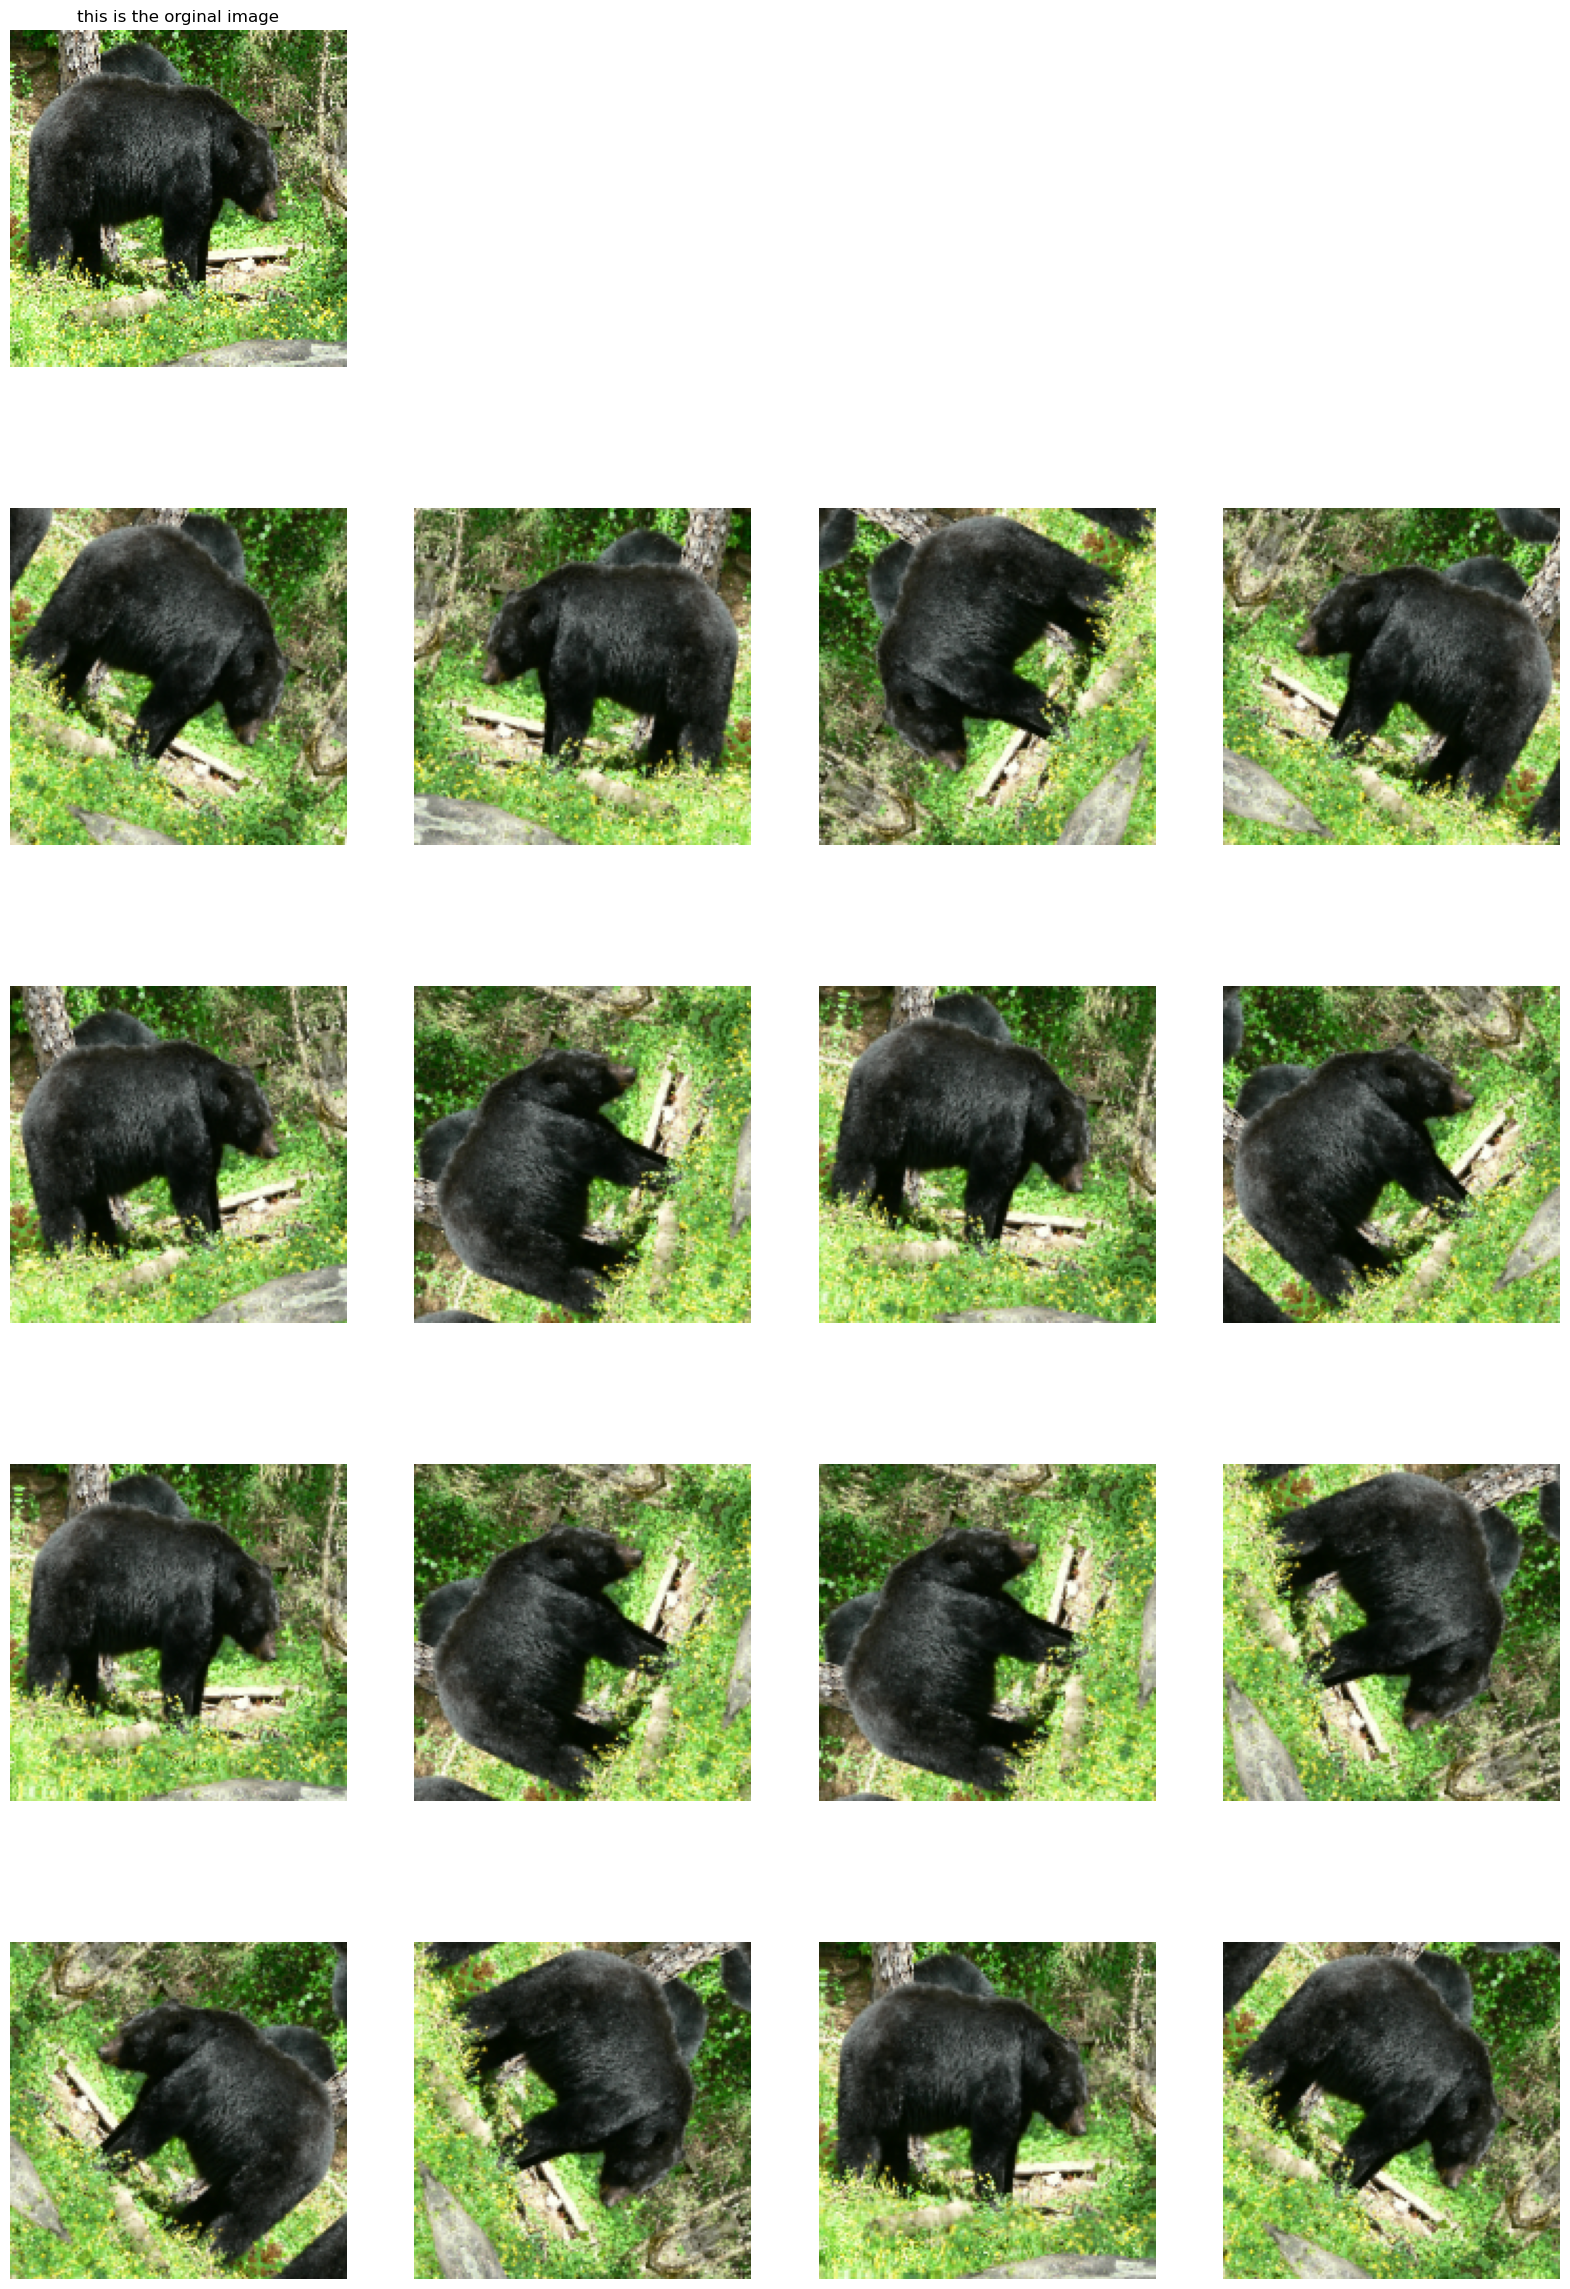

In [10]:
plt.figure(figsize=(20,30))
for batch , label in train_set.take(1):
    img = tf.cast(tf.expand_dims(batch.numpy()[0],0) ,tf.float32 )
    class_ = label[0]
    plt.subplot(5,4,1)
    plt.imshow(img[0]/255)
    plt.title("this is the orginal image")
    plt.axis("off")
    #print(img.shape,"-----")
    for i in range(16):
        plt.subplot(5,4,i+5)
    
        aug_img = augmentation(img)
        plt.imshow(aug_img[0]/255)
        plt.axis("off")
        #print(aug_img[0].shape)

before this i think data augmention apply to the main dataset and create a new brand dataset from it with the larger number of examples . but now i find out augmentation apply during training and its apply as layer of networks . so we can show more data to our model with increasing epochs number 

preprocessor 

In [11]:
preprocessor = keras.applications.mobilenet_v2.preprocess_input

In [80]:
del base_model

In [81]:
IMG_SHAPE = img_size_ + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [82]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [14]:
print(base_model.layers[-2].name , 
base_model.layers[-1].name ,sep="\n")

global_average_pooling2d
predictions


this two last layers response for prediction  and they called top layers 

In [15]:
images , labels = next(iter(train_set))

predict = base_model(images)

prediction = keras.applications.mobilenet_v2.decode_predictions(predict.numpy(),top=1)

In [16]:
for i in range(32):
    print(prediction[i] , "-----------",labels[i].numpy())

[('n04589890', 'window_screen', 0.9158901)] ----------- 1
[('n03598930', 'jigsaw_puzzle', 0.18287858)] ----------- 0
[('n04589890', 'window_screen', 0.41589743)] ----------- 1
[('n04589890', 'window_screen', 0.37686536)] ----------- 1
[('n04589890', 'window_screen', 0.48954692)] ----------- 0
[('n04589890', 'window_screen', 0.1950082)] ----------- 1
[('n04589890', 'window_screen', 0.6045667)] ----------- 1
[('n04589890', 'window_screen', 0.9070851)] ----------- 1
[('n04589890', 'window_screen', 0.14295152)] ----------- 1
[('n03598930', 'jigsaw_puzzle', 0.11344655)] ----------- 0
[('n04589890', 'window_screen', 0.15944697)] ----------- 1
[('n04589890', 'window_screen', 0.31899568)] ----------- 1
[('n04589890', 'window_screen', 0.90539)] ----------- 1
[('n01675722', 'banded_gecko', 0.20467532)] ----------- 1
[('n04589890', 'window_screen', 0.42691767)] ----------- 0
[('n01685808', 'whiptail', 0.21257183)] ----------- 1
[('n03530642', 'honeycomb', 0.11439009)] ----------- 1
[('n04589890',

this result show that our model recignise alpaca as window_screen in most of the time  

lets fix it 

In [84]:
model_base_2 = keras.Model(inputs = base_model.input , outputs = base_model.layers[-3].output)

In [85]:
model_base_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[0][0]']      

# freeze aproach for transfor learning 

In [83]:
del alpaca_model

In [86]:
# alpaca_model = keras.Sequential([
#     augmentation,
#     preprocessor(),
#     model_base_2,
#     layers.GlobalAveragePooling2D(),
#     layers.Dropout(0.2),
#     layers.Dense(1)
# ])
# we can use sequential here beacuse we want to use a function preprocessor as layer so we have to implement it with keras functional api 
model_base_2.trainable = False 
input_layer = keras.layers.Input(shape=(160,160,3))
x = augmentation(input_layer)
x = preprocessor(x)
x = model_base_2(x , training = False )
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1)(x)
alpaca_model = keras.Model(inputs=input_layer , outputs=x)

In [87]:
alpaca_model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [99]:
callback = keras.callbacks.ModelCheckpoint("checkpoints/ckp.keras",
                                           save_weights_only=True , 
                                           save_best_only=True,
                                           monitor = "val_accuracy",
                                           mode="max",
                                           verbose = 1 )
                                       

In [112]:
alpaca_model.fit(train_set , validation_data=validation_set , epochs=100 ,callbacks=[callback])

Epoch 1/100
8/8 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9520
Epoch 1: val_accuracy did not improve from 0.94805
8/8 [==============================] - 4s 465ms/step - loss: 0.1618 - accuracy: 0.9520 - val_loss: 0.2231 - val_accuracy: 0.8961
Epoch 2/100
8/8 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9440
Epoch 2: val_accuracy did not improve from 0.94805
8/8 [==============================] - 4s 406ms/step - loss: 0.1390 - accuracy: 0.9440 - val_loss: 0.2379 - val_accuracy: 0.8442
Epoch 3/100
8/8 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9640
Epoch 3: val_accuracy did not improve from 0.94805
8/8 [==============================] - 4s 420ms/step - loss: 0.1260 - accuracy: 0.9640 - val_loss: 0.2111 - val_accuracy: 0.9221
Epoch 4/100
8/8 [==============================] - ETA: 0s - loss: 0.1245 - accuracy: 0.9520
Epoch 4: val_accuracy did not improve from 0.94805
8/8 [==============================] 

In [102]:
alpaca_model.load_weights("checkpoints/ckp.keras")

In [103]:
alpaca_model.evaluate(validation_set)

3/3 [==============================] - 1s 291ms/step - loss: 0.2066 - accuracy: 0.9481


[0.20658478140830994, 0.948051929473877]

In [104]:
img = keras.preprocessing.image

In [105]:
img1 = img.load_img("images/snowalpaca.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
tf.math.sigmoid(alpaca_model.predict(img1))

1/1 [==============================] - 0s 81ms/step


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.09427568]], dtype=float32)>

use predict metod for testing model 

In [106]:
alpaca_model.predict(img1)

1/1 [==============================] - 0s 62ms/step


array([[-2.2625117]], dtype=float32)

In [107]:
alpaca_model(img1).numpy()

array([[-1.6594666]], dtype=float32)

In [108]:
image = keras.preprocessing.image

In [109]:
img2 = np.expand_dims(image.array_to_img(image.load_img("images/alpaca.png" , target_size = (160,160,3))),axis=0)
tf.math.sigmoid(alpaca_model.predict(img2))

1/1 [==============================] - 0s 81ms/step


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.03425274]], dtype=float32)>

In [110]:
#"images\1.png"
image1 = keras.preprocessing.image
img3 = np.expand_dims(image1.array_to_img(image1.load_img("images/1.png" , target_size = (160,160,3))),axis=0)
tf.math.sigmoid(alpaca_model.predict(img3))

1/1 [==============================] - 0s 84ms/step


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.6630852]], dtype=float32)>

In [111]:
#"images\1.png"
image1 = keras.preprocessing.image
img3 = np.expand_dims(image1.array_to_img(image1.load_img("images/2.png" , target_size = (160,160,3))),axis=0)
tf.math.sigmoid(alpaca_model.predict(img3))

1/1 [==============================] - 0s 67ms/step


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.04787065]], dtype=float32)>

1/1 [==============================] - 0s 82ms/step
tf.Tensor([[0.0078772]], shape=(1, 1), dtype=float32)


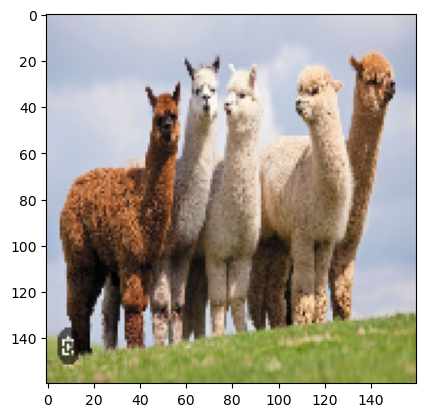

In [125]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/3.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)

1/1 [==============================] - 0s 80ms/step
tf.Tensor([[0.68893397]], shape=(1, 1), dtype=float32)


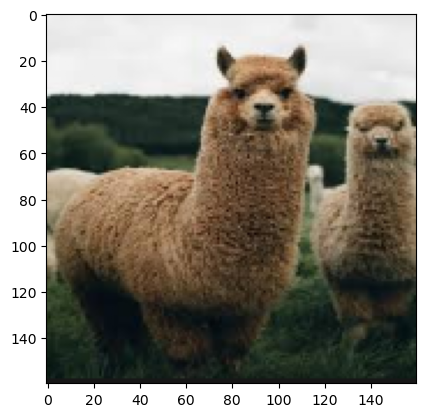

In [124]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/4.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)

1/1 [==============================] - 0s 75ms/step
tf.Tensor([[0.904204]], shape=(1, 1), dtype=float32)


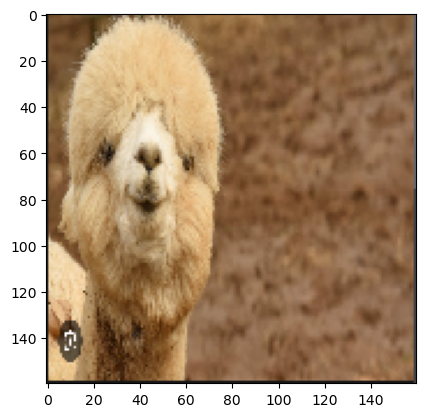

In [130]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/6.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)

1/1 [==============================] - 0s 78ms/step
tf.Tensor([[0.05701632]], shape=(1, 1), dtype=float32)


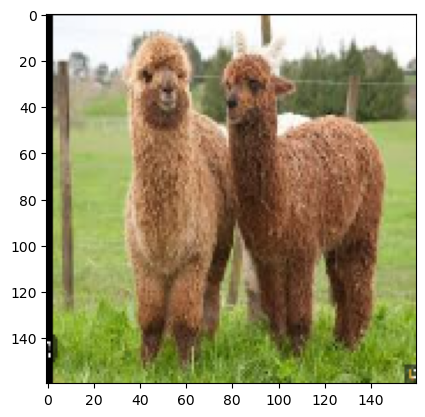

In [131]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/7.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)

# fine tuning 

In [132]:
len(model_base_2.layers)

154

In [145]:
batch_size_ = 8 
img_size_ = (160,160)
directory = "datasets/dataset/"
train_set = keras.preprocessing.image_dataset_from_directory(
    directory+"train",
    shuffle = True , 
    image_size=img_size_,
    batch_size=batch_size_
)
validation_set = keras.preprocessing.image_dataset_from_directory(
    directory+"test",
    shuffle = True , 
    image_size = img_size_,
    batch_size = batch_size_
)

Found 250 files belonging to 2 classes.
Found 77 files belonging to 2 classes.


In [149]:
model_base_2.trainable = True 

for i in model_base_2.layers[:126]:
    i.trainable= False 

alpaca_model.compile(
    optimizer = keras.optimizers.Adam(0.00001),
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ["accuracy"]
)

In [147]:
hist = alpaca_model.fit(train_set , validation_data=validation_set ,epochs=20 , callbacks = [callback])

Epoch 1/20
32/32 [==============================] - ETA: 0s - loss: 0.0180 - accuracy: 0.9960
Epoch 1: val_accuracy did not improve from 0.96104
32/32 [==============================] - 28s 263ms/step - loss: 0.0180 - accuracy: 0.9960 - val_loss: 0.2115 - val_accuracy: 0.9610
Epoch 2/20
32/32 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9960
Epoch 2: val_accuracy did not improve from 0.96104
32/32 [==============================] - 6s 177ms/step - loss: 0.0122 - accuracy: 0.9960 - val_loss: 0.2038 - val_accuracy: 0.9610
Epoch 3/20
32/32 [==============================] - ETA: 0s - loss: 0.0125 - accuracy: 0.9960
Epoch 3: val_accuracy did not improve from 0.96104
32/32 [==============================] - 6s 186ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.1926 - val_accuracy: 0.9610
Epoch 4/20
32/32 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000
Epoch 4: val_accuracy did not improve from 0.96104
32/32 [===================

In [150]:
alpaca_model.load_weights("checkpoints/ckp.keras")

In [151]:
alpaca_model.evaluate(validation_set)

10/10 [==============================] - 6s 83ms/step - loss: 0.1773 - accuracy: 0.9610


[0.1772661656141281, 0.9610389471054077]

1/1 [==============================] - 4s 4s/step
tf.Tensor([[0.07497753]], shape=(1, 1), dtype=float32)


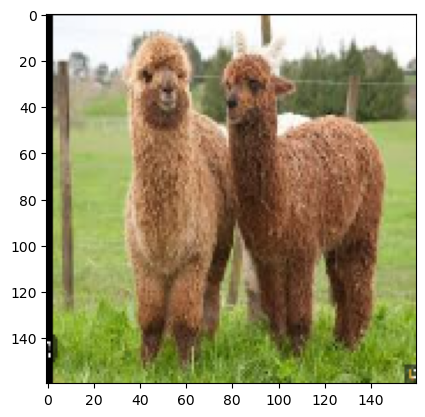

In [152]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/7.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)

1/1 [==============================] - 0s 87ms/step
tf.Tensor([[0.00781363]], shape=(1, 1), dtype=float32)


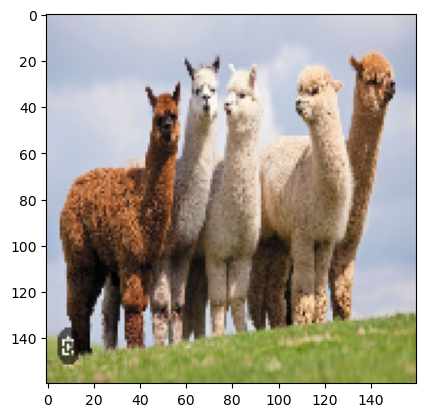

In [153]:
del img 
img = keras.preprocessing.image
img1 = img.load_img("images/3.png" , target_size=(160,160,3))#.reshape(160,160,3)
img1 = img.img_to_array(img1)
img1 = np.expand_dims(img1,axis=0)
print(tf.math.sigmoid(alpaca_model.predict(img1)))
plt.imshow(img1[0]/255)